**Evolv.Fit Challenge**
--

-by
**Sharanesh R**

In [49]:
## Importing the Required Libraries
import numpy as np
import pickle
import cv2
from os import listdir
import tensorflow as tf
from tensorflow import keras 
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [50]:
## Defining the parameters of the environment
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224, 224))
image_size = 0
directory_root = '../input/indian-cricketers-images/images'
width=224
height=224
depth=3

In [51]:
def load_img(img_path):
    try:
        image = cv2.imread(img_path)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
    
train_image_list, train_label_list = [], []
test_image_list, test_label_list = [], []
try:
    root_dir = listdir(directory_root)
    print("Loading Images")
    for player_folder in root_dir :
        player_image_list = listdir(f"{directory_root}/{player_folder}")
        print(f"Processing {player_folder} ...")
        total_images = len(player_image_list)
        train_imgaes = int(0.85*total_images)
        for image in player_image_list[0:train_imgaes]:
            image_path = f"{directory_root}/{player_folder}/{image}"
            train_image_list.append(load_img(image_path))
            train_label_list.append(player_folder)
        for image in player_image_list[train_imgaes:]:
            image_path = f"{directory_root}/{player_folder}/{image}"
            test_image_list.append(load_img(image_path))
            test_label_list.append(player_folder)

    print("Image loading completed")  
except Exception as e:
    print(f"Error : {e}")
    

Loading Images
Processing hardik_pandya ...
Processing shikhar_dhawan ...
Processing bhuvneshwar_kumar ...
Processing k._l._rahul ...
Processing kedar_jadhav ...
Processing kuldeep_yadav ...
Processing ms_dhoni ...
Processing mohammed_shami ...
Processing ravindra_jadeja ...
Processing dinesh_karthik ...
Processing vijay_shankar ...
Processing virat_kohli ...
Processing jasprit_bumrah ...
Processing yuzvendra_chahal ...
Processing rohit_sharma ...
Image loading completed


In [52]:
train_image_size = len(train_image_list)
print(train_image_size)

test_image_size = len(test_image_list)
print(test_image_size)

483
93


In [53]:
## Encoding the classes we have in our dataset
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train_label_list)
y_train = label_encoder.transform(train_label_list)
y_test = label_encoder.transform(test_label_list)
n_classes = len(label_encoder.classes_)
print(label_encoder.classes_)
print(n_classes)

## Normalising the images
x_train = np.array(train_image_list, dtype=np.float16) / 225.0
x_test = np.array(test_image_list, dtype=np.float16) / 225.0

## Spliting data to train, test
#x_train, x_test, y_train, y_test = train_test_split(image_list, image_labels, test_size=0.15, random_state = 42) 

['bhuvneshwar_kumar' 'dinesh_karthik' 'hardik_pandya' 'jasprit_bumrah'
 'k._l._rahul' 'kedar_jadhav' 'kuldeep_yadav' 'mohammed_shami' 'ms_dhoni'
 'ravindra_jadeja' 'rohit_sharma' 'shikhar_dhawan' 'vijay_shankar'
 'virat_kohli' 'yuzvendra_chahal']
15


In [54]:
## Making the Image data pipeline
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

Epoch 1/25
15/15 [==============================] - 19s 1s/step - loss: 2.8671 - accuracy: 0.1015 - val_loss: 2.8406 - val_accuracy: 0.1290
Epoch 2/25
15/15 [==============================] - 16s 1s/step - loss: 2.5933 - accuracy: 0.1499 - val_loss: 2.5730 - val_accuracy: 0.1613
Epoch 3/25
15/15 [==============================] - 16s 1s/step - loss: 2.2898 - accuracy: 0.1956 - val_loss: 2.5147 - val_accuracy: 0.1828
Epoch 4/25
15/15 [==============================] - 16s 1s/step - loss: 2.1483 - accuracy: 0.3561 - val_loss: 2.4058 - val_accuracy: 0.2151
Epoch 5/25
15/15 [==============================] - 15s 980ms/step - loss: 1.9373 - accuracy: 0.4056 - val_loss: 2.3817 - val_accuracy: 0.2043
Epoch 6/25
15/15 [==============================] - 16s 1s/step - loss: 1.8446 - accuracy: 0.4237 - val_loss: 2.3226 - val_accuracy: 0.2473
Epoch 7/25
15/15 [==============================] - 15s 1s/step - loss: 1.8101 - accuracy: 0.4423 - val_loss: 2.2724 - val_accuracy: 0.2688
Epoch 8/25
15/15 

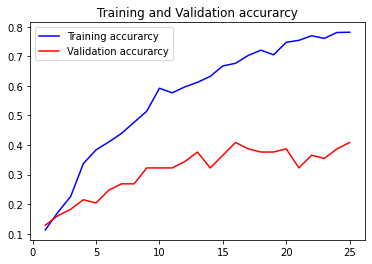

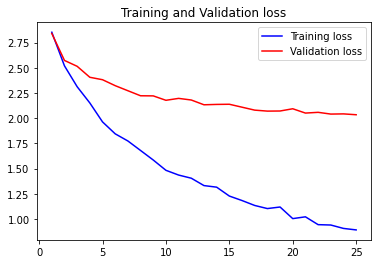

Calculating model accuracy
3/3 [==============================] - 2s 597ms/step - loss: 2.0340 - accuracy: 0.4086
Train Accuracy: 81.57349824905396
Test Accuracy: 40.860214829444885
Saving model


In [55]:
base_model = keras.applications.MobileNetV2(weights="imagenet",include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

for layer in base_model.layers:
    layer.trainable = False

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1)

## Visualising the Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print("Calculating model accuracy")
train_scores = model.evaluate(x_train, y_train)
test_scores = model.evaluate(x_test, y_test)
print(f"Train Accuracy: {train_scores[1]*100}")
print(f"Test Accuracy: {test_scores[1]*100}")

print("Saving model")
model.save("tl_model_params.h5")

Epoch 1/25
15/15 [==============================] - 48s 3s/step - loss: 3.9952 - accuracy: 0.1344 - val_loss: 3.0139 - val_accuracy: 0.1075
Epoch 2/25
15/15 [==============================] - 44s 3s/step - loss: 3.3850 - accuracy: 0.1487 - val_loss: 4.8121 - val_accuracy: 0.0538
Epoch 3/25
15/15 [==============================] - 46s 3s/step - loss: 3.1649 - accuracy: 0.1538 - val_loss: 8.6942 - val_accuracy: 0.0538
Epoch 4/25
15/15 [==============================] - 44s 3s/step - loss: 2.9397 - accuracy: 0.2045 - val_loss: 6.5521 - val_accuracy: 0.0968
Epoch 5/25
15/15 [==============================] - 44s 3s/step - loss: 2.8517 - accuracy: 0.2155 - val_loss: 7.3969 - val_accuracy: 0.0538
Epoch 6/25
15/15 [==============================] - 44s 3s/step - loss: 3.3029 - accuracy: 0.1696 - val_loss: 5.2561 - val_accuracy: 0.0753
Epoch 7/25
15/15 [==============================] - 44s 3s/step - loss: 3.0693 - accuracy: 0.1891 - val_loss: 6.9033 - val_accuracy: 0.0645
Epoch 8/25
15/15 [==

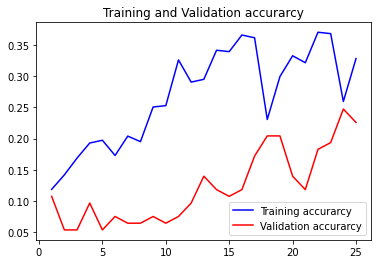

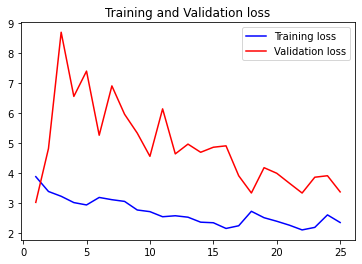

Calculating model accuracy
3/3 [==============================] - 2s 644ms/step - loss: 3.3642 - accuracy: 0.2258
Train Accuracy: 34.78260934352875
Test Accuracy: 22.580644488334656
Saving model


In [56]:
## Defining the model
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1)

## Visualising the Accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

print("Calculating model accuracy")
train_scores = model.evaluate(x_train, y_train)
test_scores = model.evaluate(x_test, y_test)
print(f"Train Accuracy: {train_scores[1]*100}")
print(f"Test Accuracy: {test_scores[1]*100}")

print("Saving model")
model.save("cnn_model_params.h5")